In [6]:
# !pip install diffusers
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torchvision import transforms

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(1.0, 0)

Using device: cuda


Input shape: torch.Size([8, 3, 32, 32])
Labels: tensor([88, 70, 56, 10, 94, 46, 55, 81])


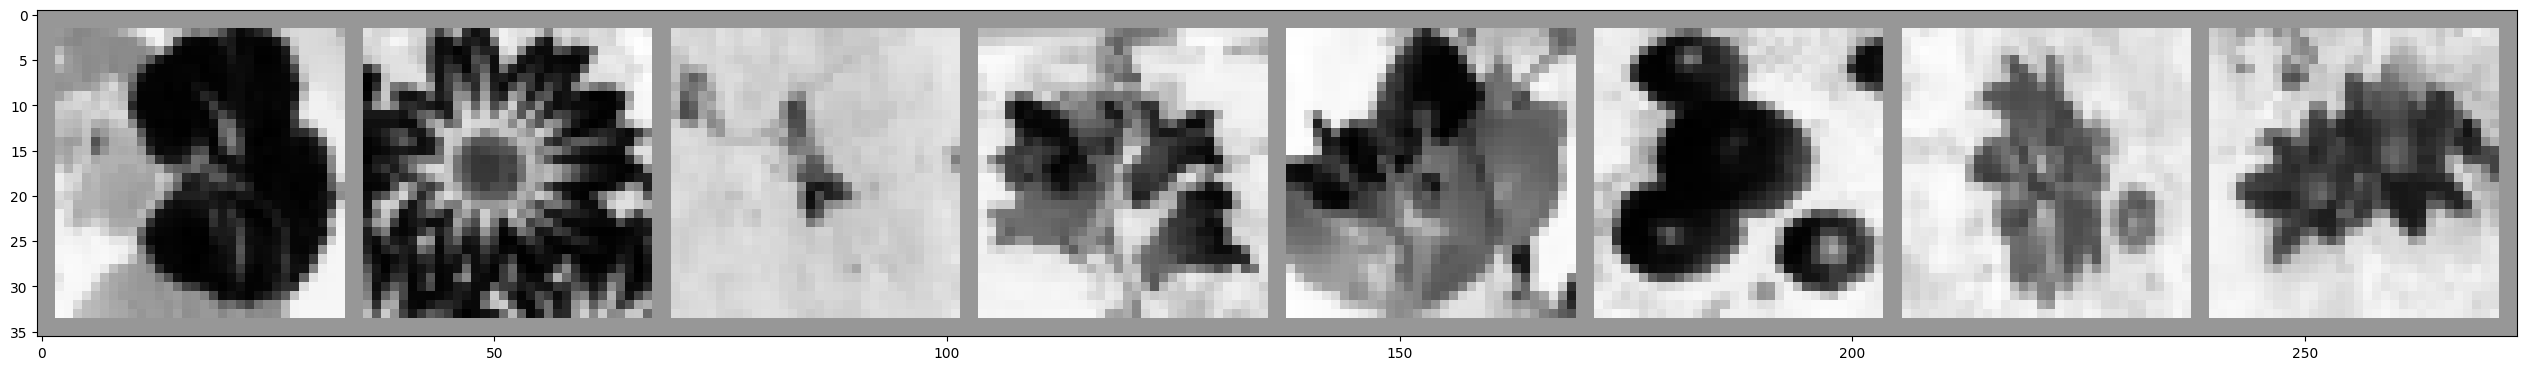

In [7]:
def load_transformed_dataset(img_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)
    train = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform)
    test = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])

S = 32
dataset = load_transformed_dataset(S)

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
fig, ax = plt.subplots(1, 1, figsize=(S, S))
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [8]:
C = 102

class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=C , class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=S,           # the target image resolution
            in_channels=3 + class_emb_size, # Additional input channels for class cond.
            out_channels=3,           # the number of output channels
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape

        # class conditioning in right shape to add as additional input channels
        class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

        # Feed this to the unet alongside the timestep and return the prediction
        return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [9]:
# Create a scheduler
T = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=T, beta_schedule='squaredcos_cap_v2')

  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.208703


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.181038


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.166060


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.155890


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.150266


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.142944


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.141855


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.140108


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.132852


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.139902


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 10. Average of the last 100 loss values: 0.139827


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 11. Average of the last 100 loss values: 0.131509


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 12. Average of the last 100 loss values: 0.133059


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 13. Average of the last 100 loss values: 0.134734


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 14. Average of the last 100 loss values: 0.134571


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 15. Average of the last 100 loss values: 0.134376


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 16. Average of the last 100 loss values: 0.128545


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 17. Average of the last 100 loss values: 0.136372


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 18. Average of the last 100 loss values: 0.127743


  0%|          | 0/225 [00:00<?, ?it/s]

Finished epoch 19. Average of the last 100 loss values: 0.133412


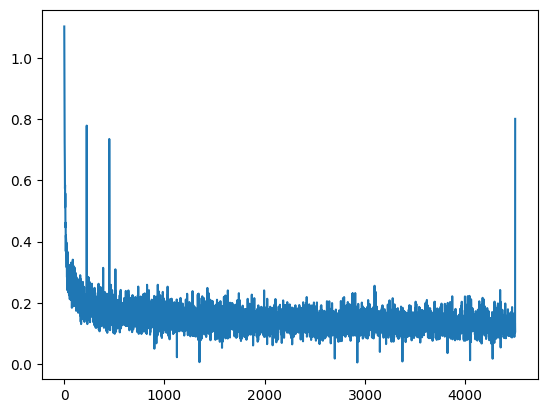

In [16]:
# Training loop:

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# How many runs through the data should we do?
n_epochs = 20

# Our network
net = ClassConditionedUnet().to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=0.0005)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, T - 1, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

In [17]:
torch.save(net, './model.pt')
net = torch.load('./model.pt')

0it [00:00, ?it/s]

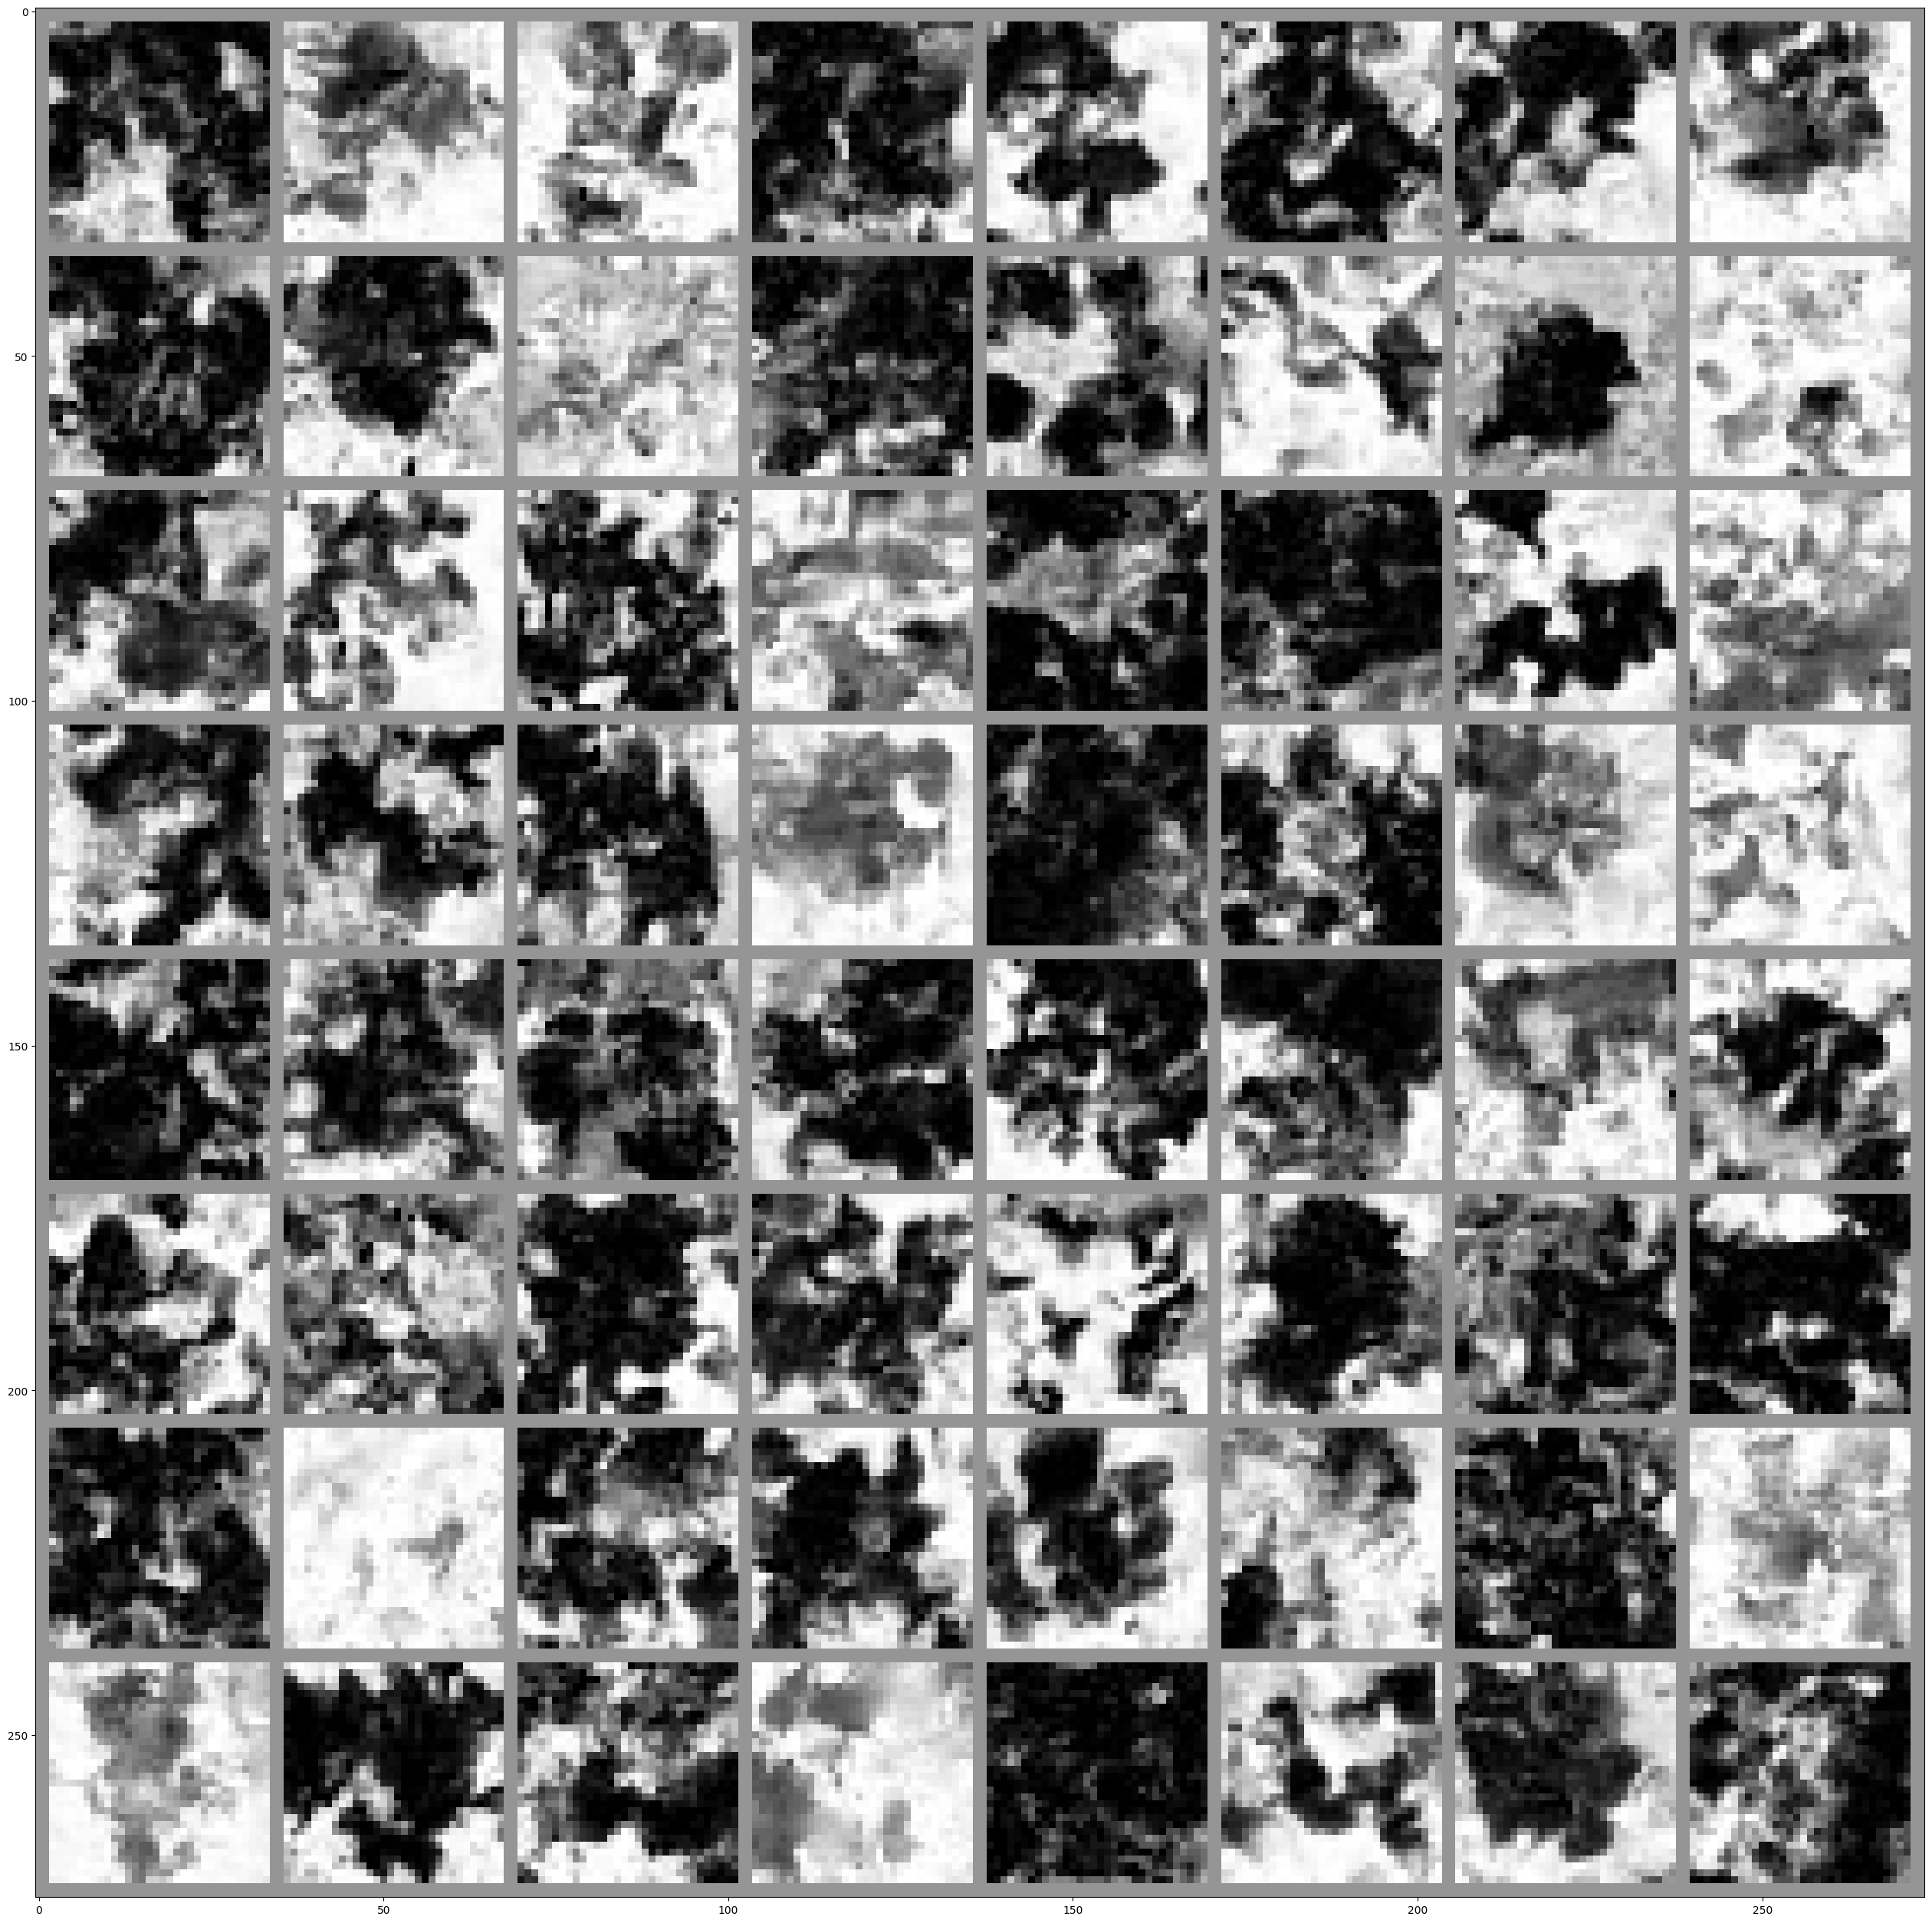

In [20]:
# Sampling some different labels:

D = 8

# Prepare random x to start from, plus some desired labels y
x = torch.randn(8 * D, 3, S, S).to(device)
y = torch.tensor([[i]*8 for i in range(D)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(S, S))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1))[0], cmap='Greys')